In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import umap.umap_ as umap



In [2]:
df = pd.read_csv('./dataset.csv')
df.columns = [ i.replace(' ','_').lower().strip() for i in df.columns]

In [3]:
# hay 1 projecto con `project_priority` = np.nan, drop it.
df = df[df['project_priority'].notnull()]

# Usamos solo los proyectos finalizados
df = df[df['state'] == '(3) Closed']


##### Feature Engineering

In [4]:
df['project_priority'] = df['project_priority'].apply(lambda x: int(x.split(')')[0].replace('(','')))

# Imputamos la feature `tota_headcount` & `num_tasks` con la mediana.
df['total_headcount'] = df['total_headcount'].fillna(df['total_headcount'].median())
df['num_tasks'] = df['num_tasks'].fillna(df['num_tasks'].median())

# Limpiamos la variable para volverla `float`
for i in ['avg_risk_exposure']:
    df[i] = df[i].apply(lambda x: x.replace(',','.'))
    df[i]  = df[i].astype(float)

In [5]:
k_means_columns = ['project_priority','avg_risk_exposure','total_headcount','num_tasks','duration']

#### Train - Test Split, 70/30

In [6]:
X = df[k_means_columns] 
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

### PCA

In [7]:
preprocessing_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('umap', umap.UMAP(n_components=2, random_state=42))
])

In [8]:
# Pipeline en Train (Fit & Transform)
X_train_umap = preprocessing_pipeline.fit_transform(X_train)


# Pipeline en Test (Transform)
X_test_umap = preprocessing_pipeline.transform(X_test)

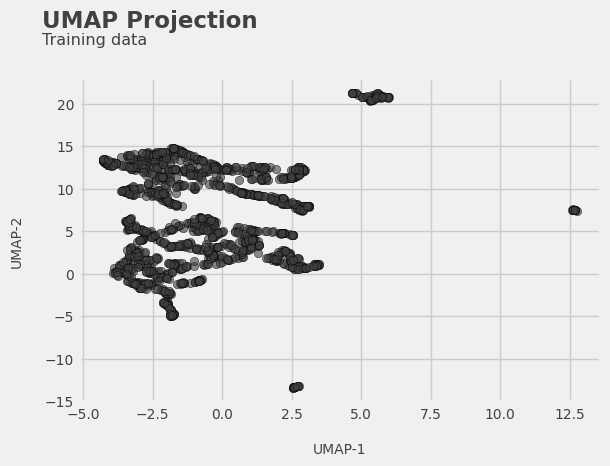

In [26]:
plt.figure(figsize=(6, 4))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], alpha=0.6, edgecolor='k', color = '#414141')

plt.ylabel('UMAP-2', fontsize = 10, color = '#414141',labelpad = 15)
plt.xlabel('UMAP-1', fontsize = 10, color = '#414141',labelpad = 15)

plt.yticks( fontsize = 10, color = '#414141');
plt.xticks( fontsize = 10, color = '#414141');


plt.text(x=-6.5, y=29, s = "UMAP Projection", fontsize = 16.5, fontweight = 'bold', color = '#414141')
plt.text(x=-6.5, y=27, s = "Training data", fontsize = 11.5,  color = '#414141')

plt.show()

In [13]:
from sklearn.manifold import trustworthiness

score = trustworthiness(X_train, X_train_umap, n_neighbors=2)
print(f"Trustworthiness of UMAP embedding: {score:.4f}")

Trustworthiness of UMAP embedding: 0.8983


Un trustworthiness de 0.8983 significa que aproximadamente el 89.8% de las relaciones de vecindad locales se conservaron correctamente después de la reducción de dimensión con UMAP.

En otras palabras: los puntos que eran vecinos en el espacio original en su mayoría siguen siendo vecinos en el embedding UMAP

#### K-Means with K=2

In [28]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_umap)

labels = kmeans.labels_

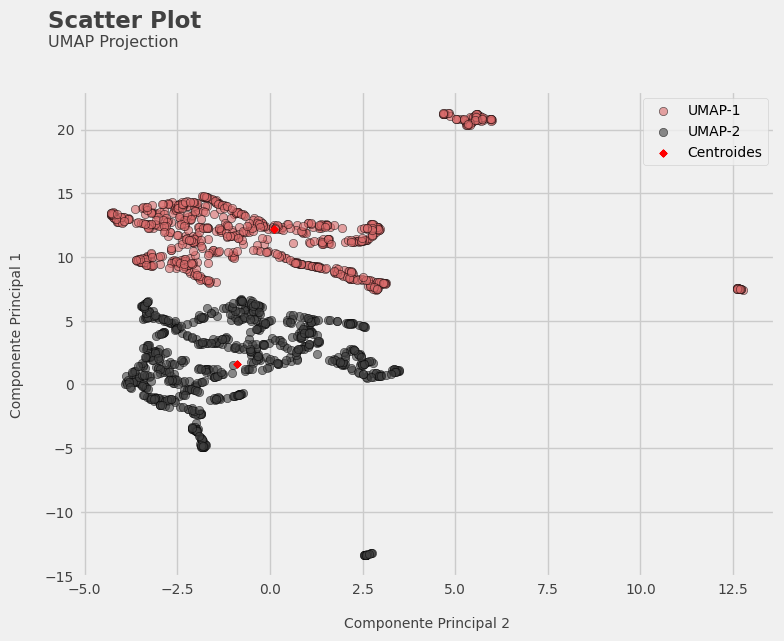

In [34]:
colores = ['#DA6C6C', '#414141'] 

plt.figure(figsize=(8, 6))

for cluster in range(2):
    plt.scatter(
        X_train_umap[labels == cluster, 0],
        X_train_umap[labels == cluster, 1],
        color=colores[cluster],
        alpha=0.6,
        edgecolor='k',
        label=f'UMAP-{cluster+1}'
    )


centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=10, marker='x', label='Centroides')


plt.text(x=-6, y=28, s = "Scatter Plot", fontsize = 16.5, fontweight = 'bold', color = '#414141')
plt.text(x=-6, y=26.5, s = "UMAP Projection", fontsize = 11.5, color = '#414141')

plt.ylabel('Componente Principal 1', fontsize=10, color='#414141', labelpad=15)
plt.xlabel('Componente Principal 2', fontsize=10, color='#414141', labelpad=15)

plt.yticks(fontsize=10, color='#414141')
plt.xticks(fontsize=10, color='#414141')

plt.legend(loc = 'upper right',fancybox = True, fontsize = 10)

plt.grid(True)
plt.show()


In [35]:
sil_score = silhouette_score(X_train_umap, labels)
db_index = davies_bouldin_score(X_train_umap, labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")

Silhouette Score: 0.5314
Davies-Bouldin Index: 0.6942


In [36]:
X_train['Kmeans_labels'] = labels

In [44]:
X_train.groupby(['Kmeans_labels']).describe()

project_priority                                               \
                         count      mean       std  min  25%  50%  75%  max   
Kmeans_labels                                                                 
0                        730.0  2.916438  0.398734  1.0  3.0  3.0  3.0  4.0   
1                        751.0  2.998668  0.036491  2.0  3.0  3.0  3.0  3.0   

              avg_risk_exposure                                         \
                          count      mean       std  min     25%   50%   
Kmeans_labels                                                            
0                         730.0  4.174068  2.574197  0.0  2.1675  4.81   
1                         751.0  0.271944  0.716834  0.0  0.0000  0.00   

                            total_headcount                               \
                  75%   max           count        mean         std  min   
Kmeans_labels                                                              
0              5.8175  9.50           730.0   87.305479  137.356709  0.0   
1              0.3150  6.46           751.0  151.149134  738.368818  0.0   

                                         num_tasks                             \
                25%   50%   75%      max     count       mean        std  min   
Kmeans_labels                                                                   
0              51.0  51.0  51.0   1593.0     730.0  85.347945  92.482702  1.0   
1              51.0  51.0  51.0  15000.0     751.0  42.560586  32.499005  1.0   

                                         duration                              \
                25%   50%     75%    max    count        mean        std  min   
Kmeans_labels                                                                   
0              30.0  49.0  108.75  805.0    730.0  122.388479  89.614637  0.0   
1              19.0  38.0   59.00  175.0    751.0   72.682290  43.430096  0.0   

                                          
                25%   50%     75%    max  
Kmeans_labels                             
0              64.0  97.0  148.75  587.0  
1              42.0  68.0   98.50  254.0

### Interpretacion:

**Cluster 0:** “Proyectos complejos, de alta prioridad y riesgo”

**Tamaño del cluster:** 730 proyectos
<hr>

| Variable             | Cluster 0 – Complejos y de alta prioridad | Cluster 1 – Rutinarios y de bajo riesgo |
|----------------------|--------------------------------------------|------------------------------------------|
| **Tamaño del cluster** | 730 proyectos                              | 751 proyectos                            |
| **Prioridad**        | 2.91 (media), mayoría con valor 3 o 4       | 2.99 (media), casi todos con valor 3     |
| **Riesgo**           | 4.17 (riesgo medio-alto)                    | 0.27 (riesgo extremadamente bajo)        |
| **Headcount**        | 87.31 (media), máx. 1593                    | 151.15 (media), máx. 15,000, con alta dispersión |
| **Número de tareas** | 85.35 (alta carga operativa)                | 42.56 (baja carga operativa)             |
| **Duración (días)**  | 122.39 (larga duración)                     | 72.68 (corta-media duración)             |




| Característica       | Cluster 0 (Complejos)         | Cluster 1 (Rutinarios)         |
|----------------------|-------------------------------|--------------------------------|
| Prioridad            | Moderada a alta               | Media, sin variación           |
| Riesgo               | Medio-alto                    | Muy bajo                       |
| Headcount            | Moderado con algunos picos    | Muy alto pero muy disperso     |
| Tareas               | Muchas                        | Menos                          |
| Duración             | Larga                         | Corta a media                  |
